<a href="https://colab.research.google.com/github/IfeakanduBenedict/pediatric-pneumonia-ml-england/blob/main/Pediatric_Pneumonia_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Topic: Predicting Pediatric Pneumonia Hospitalisation Rates in English Local Authorities**
   
## Research Questions

**PRIMARY**: To what extent can machine learning models predict emergency pneumonia hospitalisation rates among children and young people under 19 across English Local Authorities using socioeconomic deprivation, demographic vulnerability, and healthcare utilisation indicators?

**SECONDARY**: Which socioeconomic, demographic, and healthcare-related factors contribute most to geographic inequalities in pneumonia hospitalisation rates among children and young people under 19 across England?


# **Notebook Setup and Installation of Needed Library**

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler

# Import Variance Inflation Factor (VIF) to detect multicollinearity
# between predictor variables during feature evaluation.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import hyperparameter tuning tools for model optimization
# GridSearchCV performs exhaustive parameter search,
# while RandomizedSearchCV samples parameter combinations for faster exploration.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Machine Learning - Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Import statistical tests for regression assumptions validation
# shapiro, normaltest: Test normality of residuals
# het_breuschpagan: Test homoscedasticity (constant variance)
# durbin_watson: Test independence (no autocorrelation)
from scipy.stats import shapiro, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Import statsmodels for adding constant (required by Breusch-Pagan test)
import statsmodels.api as sm

# Machine Learning - Metrics
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)

# Model Interpretation
import shap
from sklearn.inspection import permutation_importance

# Model Persistence
import joblib
import json
from datetime import datetime

# For handling file paths
import os

# Settings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✓ All libraries imported successfully!")
print(f"✓ Random seed set to: {RANDOM_STATE}")

✓ All libraries imported successfully!
✓ Random seed set to: 42


# **Connecting Google Drive**

In [ ]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Navigating to the dataset folder in Google Drive
os.chdir('/content/drive/MyDrive/')

## **Loading The Dataset**

In [ ]:
# Load the dataset
pneumonia_data = pd.read_csv('pediatric_pneumonia_england_LA_dataset_2023_2024.csv')

# **Dataset Overview**

In [ ]:
# Displaying the first five rows.
pneumonia_data.head()

,Area_Code,Area_Name,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct,Fuel_Poverty_Pct,Free_School_Meals_Pct,Pop_0_4_Years_Pct,Population_Density,Ethnic_Minority_Pct,Overcrowded_HH_Pct,Infant_Mortality_Rate,Birth_Rate_per_1000,Emergency_Admissions_U18,Respiratory_Admissions_0_4,Emergency_Admissions_0_4
0,E07000223,Adur,592.0,17.59,15.3,9.69,38.39,113.75,1538.65,11.07,25.96,4.60,48.40,55.79,178.75,118.62
1,E07000032,Amber Valley,405.2,17.97,21.3,11.94,37.06,84.52,478.30,4.96,29.53,3.95,50.28,39.93,126.77,86.21
2,E07000224,Arun,681.4,18.64,17.4,9.52,34.68,154.41,752.88,11.35,28.75,2.67,47.68,73.94,224.59,167.74
3,E07000170,Ashfield,748.9,26.31,28.2,12.27,34.98,74.14,1160.12,8.18,42.70,5.33,50.73,70.80,229.83,174.23
4,E07000105,Ashford,911.8,18.55,17.1,9.86,34.15,118.05,233.79,17.38,30.65,5.94,53.30,74.18,282.00,180.35


In [ ]:
# Dispalying the last five rows.
pneumonia_data.tail()

,Area_Code,Area_Name,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct,Fuel_Poverty_Pct,Free_School_Meals_Pct,Pop_0_4_Years_Pct,Population_Density,Ethnic_Minority_Pct,Overcrowded_HH_Pct,Infant_Mortality_Rate,Birth_Rate_per_1000,Emergency_Admissions_U18,Respiratory_Admissions_0_4,Emergency_Admissions_0_4
277,E07000229,Worthing,713.9,17.01,14.9,10.27,38.33,119.26,3444.72,14.96,25.69,1.85,45.12,63.00,228.58,139.14
278,E07000238,Wychavon,522.7,15.77,16.6,15.01,34.94,79.74,202.77,9.39,23.21,3.31,50.15,58.77,175.44,127.59
279,E07000128,Wyre,950.2,20.86,19.6,11.50,36.55,104.52,407.30,4.26,39.32,5.33,46.17,100.17,324.00,244.57
280,E07000239,Wyre Forest,519.2,22.44,24.2,15.82,32.80,65.88,523.56,7.51,30.27,5.95,49.88,54.49,175.67,115.28
281,E06000014,York,1061.4,11.73,15.8,12.27,38.06,119.62,750.60,12.75,28.20,3.75,30.95,99.24,322.97,241.03


In [ ]:
# Dataset Information
pneumonia_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Area_Code                   282 non-null    object 
 1   Area_Name                   282 non-null    object 
 2   Pneumonia_Rate_per_100k     281 non-null    float64
 3   IMD_Score                   282 non-null    float64
 4   Child_Poverty_Pct           282 non-null    float64
 5   Fuel_Poverty_Pct            282 non-null    float64
 6   Free_School_Meals_Pct       282 non-null    float64
 7   Pop_0_4_Years_Pct           282 non-null    float64
 8   Population_Density          282 non-null    float64
 9   Ethnic_Minority_Pct         282 non-null    float64
 10  Overcrowded_HH_Pct          282 non-null    float64
 11  Infant_Mortality_Rate       282 non-null    float64
 12  Birth_Rate_per_1000         282 non-null    float64
 13  Emergency_Admissions_U18    282 non

In [ ]:
# Dataset Description
pneumonia_data.describe()

,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct,Fuel_Poverty_Pct,Free_School_Meals_Pct,Pop_0_4_Years_Pct,Population_Density,Ethnic_Minority_Pct,Overcrowded_HH_Pct,Infant_Mortality_Rate,Birth_Rate_per_1000,Emergency_Admissions_U18,Respiratory_Admissions_0_4,Emergency_Admissions_0_4
count,281.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00
mean,618.38,19.95,20.22,11.09,38.14,91.59,1920.86,22.30,31.51,3.91,49.88,68.32,209.45,152.24
std,251.15,8.10,8.36,2.77,3.84,29.70,2552.50,18.96,11.57,1.41,6.09,22.44,76.07,56.86
min,44.60,5.54,5.60,6.20,28.93,25.45,64.60,3.43,12.71,1.22,27.92,25.99,50.17,42.64
25%,427.40,13.47,14.05,8.98,35.56,70.28,296.70,8.25,22.72,2.97,47.14,52.57,156.62,112.11
50%,596.80,18.73,18.60,10.71,37.77,87.76,968.09,15.39,29.76,3.72,50.57,67.69,200.06,147.27
75%,784.80,25.76,25.18,12.66,40.18,110.34,2585.58,29.32,39.46,4.63,53.36,82.54,259.09,188.19
max,1492.60,45.04,44.60,21.32,50.64,252.16,16388.46,85.24,77.86,8.67,67.24,163.98,486.31,384.55


In [ ]:
# Displaying the shape of the dataset
pneumonia_data.shape

(282, 16)

In [ ]:
#Checking for missing values
pneumonia_data.isnull().sum()

,0
Area_Code,0
Area_Name,0
Pneumonia_Rate_per_100k,1
IMD_Score,0
Child_Poverty_Pct,0
Fuel_Poverty_Pct,0
Free_School_Meals_Pct,0
Pop_0_4_Years_Pct,0
Population_Density,0
Ethnic_Minority_Pct,0


# **Data Cleaning**

 **Drop ID columns**

In [ ]:
# Drop Area_Code and Area_Name as they are identifiers, not predictive features
pneumonia_data = pneumonia_data.drop(columns=["Area_Code", "Area_Name" , "Respiratory_Admissions_0_4" , "Emergency_Admissions_U18"])

**Rename Column**

In [ ]:
# Correct misleading column name for clarity
pneumonia_data = pneumonia_data.rename(columns={"Pop_0_4_Years_Pct": "Pop_0_4_Index"})

## **Dataset Information & Structure**

In [ ]:
# Dataset information
print("Dataset Info:")
pneumonia_data.info()

print("VARIABLE CATEGORIES")

# Categorize variables
target = ['Pneumonia_Rate_per_100k']
identifiers = ['Area_Code', 'Area_Name']
socioeconomic = ['IMD_Score', 'Child_Poverty_Pct', 'Fuel_Poverty_Pct', 'Free_School_Meals_Pct']
demographic = ['Pop_0_4_Years_Pct', 'Ethnic_Minority_Pct', 'Birth_Rate_per_1000']
housing_geographic = ['Population_Density', 'Overcrowded_HH_Pct']
health_utilization = ['Infant_Mortality_Rate', 'Emergency_Admissions_U18',
                      'Respiratory_Admissions_0_4', 'Emergency_Admissions_0_4']

print("\n TARGET VARIABLE:")
for var in target:
    print(f"  • {var}")

print("\n SOCIOECONOMIC DEPRIVATION (4 variables):")
for var in socioeconomic:
    print(f"  • {var}")

print("\n DEMOGRAPHIC VULNERABILITY (3 variables):")
for var in demographic:
    print(f"  • {var}")

print("\n HOUSING/GEOGRAPHIC (2 variables):")
for var in housing_geographic:
    print(f"  • {var}")

print("\n HEALTH SYSTEM UTILISATION (4 variables):")
for var in health_utilization:
    print(f"  • {var}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pneumonia_Rate_per_100k   281 non-null    float64
 1   IMD_Score                 282 non-null    float64
 2   Child_Poverty_Pct         282 non-null    float64
 3   Fuel_Poverty_Pct          282 non-null    float64
 4   Free_School_Meals_Pct     282 non-null    float64
 5   Pop_0_4_Index             282 non-null    float64
 6   Population_Density        282 non-null    float64
 7   Ethnic_Minority_Pct       282 non-null    float64
 8   Overcrowded_HH_Pct        282 non-null    float64
 9   Infant_Mortality_Rate     282 non-null    float64
 10  Birth_Rate_per_1000       282 non-null    float64
 11  Emergency_Admissions_0_4  282 non-null    float64
dtypes: float64(12)
memory usage: 26.6 KB
VARIABLE CATEGORIES

 TARGET VARIABLE:
  • Pneumonia_Rate_per_100k

 

## **Handle Missing Values**

In [ ]:
# Check for missing values
missing = pneumonia_data.isnull().sum()
missing_pct = (pneumonia_data.isnull().sum() / len(pneumonia_data)) * 100
missing_data_report = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
missing_data_report = missing_data_report[missing_data_report['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data_report) > 0:
    print("Missing Values Detected:")
    print(missing_data_report)

    # Identify which LA has missing target
    missing_la_rows = pneumonia_data[pneumonia_data['Pneumonia_Rate_per_100k'].isnull()]
    if len(missing_la_rows) > 0:
        # Area_Name column was dropped earlier, so it cannot be directly accessed here.
        # Original intent was to print the name of the LA with missing data.
        print("\nNote: Area_Name column was dropped earlier. Cannot identify specific LA with missing pneumonia rate.")

    # Remove observations with missing target variable
    print("\n Removing observation(s) with missing target variable...")
    pneumonia_data = pneumonia_data.dropna(subset=['Pneumonia_Rate_per_100k']).copy()
    print(f"✓ Final dataset shape: {pneumonia_data.shape}")
else:
    print("✓ No missing values detected!")

print(f"\n✓ Working with {len(pneumonia_data)} Local Authorities")

Missing Values Detected:
                         Missing_Count  Percentage
Pneumonia_Rate_per_100k              1        0.35

Note: Area_Name column was dropped earlier. Cannot identify specific LA with missing pneumonia rate.

 Removing observation(s) with missing target variable...
✓ Final dataset shape: (281, 12)

✓ Working with 281 Local Authorities


# **EXPLORATORY DATA ANALYSIS (EDA)**

## **Descriptive Statistics**

In [ ]:
print("DESCRIPTIVE STATISTICS")

# Summary statistics for all numeric variables
desc_stats = pneumonia_data.describe().T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['cv'] = (desc_stats['std'] / desc_stats['mean']) * 100

print("\nSummary Statistics (All Variables):")
desc_stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'cv']]

DESCRIPTIVE STATISTICS

Summary Statistics (All Variables):


,mean,std,min,25%,50%,75%,max,range,cv
Pneumonia_Rate_per_100k,618.38,251.15,44.60,427.40,596.80,784.80,1492.60,1448.00,40.61
IMD_Score,19.94,8.11,5.54,13.46,18.64,25.78,45.04,39.50,40.66
Child_Poverty_Pct,20.24,8.37,5.60,14.20,18.70,25.20,44.60,39.00,41.34
Fuel_Poverty_Pct,11.10,2.77,6.20,8.98,10.76,12.67,21.32,15.12,24.92
Free_School_Meals_Pct,38.11,3.81,28.93,35.56,37.76,40.14,50.64,21.71,10.00
Pop_0_4_Index,91.68,29.71,25.45,70.46,87.78,110.53,252.16,226.71,32.41
Population_Density,1887.47,2494.58,64.60,296.41,959.76,2581.78,16388.46,16323.86,132.17
Ethnic_Minority_Pct,22.16,18.85,3.43,8.23,15.26,28.91,85.24,81.81,85.04
Overcrowded_HH_Pct,31.52,11.59,12.71,22.72,29.77,39.51,77.86,65.15,36.78
Infant_Mortality_Rate,3.90,1.41,1.22,2.97,3.72,4.63,8.67,7.45,36.09


## **Target Variable Analysis**

In [ ]:
print("TARGET VARIABLE: Pneumonia_Rate_per_100k")

target_col = 'Pneumonia_Rate_per_100k'

print(f"\nMean: {pneumonia_data[target_col].mean():.2f}")
print(f"Median: {pneumonia_data[target_col].median():.2f}")
print(f"Std Dev: {pneumonia_data[target_col].std():.2f}")
print(f"Min: {pneumonia_data[target_col].min():.2f}")
print(f"Max: {pneumonia_data[target_col].max():.2f}")
print(f"Range: {pneumonia_data[target_col].max() - pneumonia_data[target_col].min():.2f}")
print(f"Skewness: {pneumonia_data[target_col].skew():.3f}")
print(f"Kurtosis: {pneumonia_data[target_col].kurtosis():.3f}")

print("Top 5 LAs with HIGHEST Pneumonia Rates:")
top_5 = pneumonia_data.nlargest(5, target_col)[[target_col, 'IMD_Score', 'Child_Poverty_Pct']]
display(top_5)

print("Top 5 LAs with LOWEST Pneumonia Rates:")
bottom_5 = pneumonia_data.nsmallest(5, target_col)[[target_col, 'IMD_Score', 'Child_Poverty_Pct']]
display(bottom_5)

TARGET VARIABLE: Pneumonia_Rate_per_100k

Mean: 618.38
Median: 596.80
Std Dev: 251.15
Min: 44.60
Max: 1492.60
Range: 1448.00
Skewness: 0.334
Kurtosis: 0.014
Top 5 LAs with HIGHEST Pneumonia Rates:


,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct
60,1492.6,25.66,28.0
70,1324.7,12.76,15.8
84,1274.7,16.21,17.6
145,1214.8,16.93,18.3
89,1208.4,15.88,19.0


Top 5 LAs with LOWEST Pneumonia Rates:


,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct
115,44.6,21.49,16.8
121,50.3,21.53,10.1
68,54.7,22.71,16.8
267,76.7,20.34,14.4
103,131.1,15.03,16.1


**Target Variable Distribution**

The pneumonia rate demonstrates substantial variability across local authorities, with noticeable positive skewness and elevated kurtosis, indicating the presence of high-burden outliers. Comparison of the highest and lowest incidence areas suggests a clear association with socioeconomic deprivation, as reflected by IMD scores and child poverty levels. These findings support the use of non-linear modelling approaches and reinforce the relevance of deprivation-related predictors.

## **Correlation Analysis**

In [ ]:
print("CORRELATION ANALYSIS WITH TARGET VARIABLE")

# Calculate correlations with target
numeric_cols = pneumonia_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target_col]

correlations = []
for col in numeric_cols:
    corr, p_value = pearsonr(pneumonia_data[col].dropna(),
                             pneumonia_data[target_col].loc[pneumonia_data[col].dropna().index])
    correlations.append({
        'Feature': col,
        'Correlation': corr,
        'P_Value': p_value,
        'Significance': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    })

corr_pneumonia_data = pd.DataFrame(correlations).sort_values('Correlation', ascending=False, key=abs)

print("\nCorrelations with Pneumonia Rate (sorted by absolute value):")
print("*** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print()
display(corr_pneumonia_data)

print("Top 5 Strongest Predictors:")
top_corr = corr_pneumonia_data.head(5)
for idx, row in top_corr.iterrows():
    print(f"  {row['Feature']:.<40} r = {row['Correlation']:>7.3f} {row['Significance']}")

CORRELATION ANALYSIS WITH TARGET VARIABLE

Correlations with Pneumonia Rate (sorted by absolute value):
*** p<0.001, ** p<0.01, * p<0.05, ns = not significant



,Feature,Correlation,P_Value,Significance
10,Emergency_Admissions_0_4,0.79,8.94e-62,***
4,Pop_0_4_Index,0.60,6.90e-29,***
6,Ethnic_Minority_Pct,-0.43,3.57e-14,***
5,Population_Density,-0.37,1.26e-10,***
3,Free_School_Meals_Pct,-0.29,4.86e-07,***
7,Overcrowded_HH_Pct,0.21,4.61e-04,***
1,Child_Poverty_Pct,0.20,6.57e-04,***
2,Fuel_Poverty_Pct,0.19,1.80e-03,**
0,IMD_Score,0.14,2.06e-02,*
8,Infant_Mortality_Rate,0.04,4.53e-01,ns


Top 5 Strongest Predictors:
  Emergency_Admissions_0_4................ r =   0.792 ***
  Pop_0_4_Index........................... r =   0.600 ***
  Ethnic_Minority_Pct..................... r =  -0.432 ***
  Population_Density...................... r =  -0.372 ***
  Free_School_Meals_Pct................... r =  -0.295 ***


**Predictor Correlation Analysis**

Pearson correlation analysis revealed that respiratory admissions among children aged 0–4, emergency pediatric admissions, and deprivation-related indicators demonstrated the strongest statistically significant associations with pneumonia rates (p < 0.001). Several socioeconomic variables also exhibited high inter-correlation, suggesting potential multicollinearity. These findings informed subsequent model selection and supported the inclusion of both linear regression and tree-based methods to capture complex relationships.

## **Deprivation Gradient Analysis**

In [ ]:
print("DEPRIVATION GRADIENT ANALYSIS")

# Create IMD quintiles
pneumonia_data['IMD_Quintile'] = pd.qcut(pneumonia_data['IMD_Score'], q=5,
                               labels=['Q1 (Least)', 'Q2', 'Q3', 'Q4', 'Q5 (Most)'])

quintile_stats = pneumonia_data.groupby('IMD_Quintile')[target_col].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(2)

print("\nPneumonia Rates by IMD Quintile:")
display(quintile_stats)

# Calculate deprivation gradient
least_deprived_mean = quintile_stats.loc['Q1 (Least)', 'Mean']
most_deprived_mean = quintile_stats.loc['Q5 (Most)', 'Mean']
pct_difference = ((most_deprived_mean - least_deprived_mean) / least_deprived_mean) * 100

print("DEPRIVATION GRADIENT:")
print(f"Least Deprived (Q1) Mean: {least_deprived_mean:.2f} per 100,000")
print(f"Most Deprived (Q5) Mean:  {most_deprived_mean:.2f} per 100,000")
print(f"\n Percentage Difference: {pct_difference:+.1f}%")

if pct_difference > 0:
    print(f"\n  Most deprived areas have {pct_difference:.1f}% HIGHER pneumonia rates")
else:
    print(f"\n✓ Most deprived areas have {abs(pct_difference):.1f}% LOWER pneumonia rates")

DEPRIVATION GRADIENT ANALYSIS

Pneumonia Rates by IMD Quintile:


,Count,Mean,Median,Std,Min,Max
IMD_Quintile,,,,,,
Q1 (Least),57,572.76,547.80,201.48,196.2,1067.8
Q2,56,616.45,596.45,257.86,131.1,1324.7
Q3,56,625.38,605.05,261.54,76.7,1214.8
Q4,56,577.77,569.25,280.45,44.6,1492.6
Q5 (Most),56,700.36,699.40,235.59,212.8,1131.8


DEPRIVATION GRADIENT:
Least Deprived (Q1) Mean: 572.76 per 100,000
Most Deprived (Q5) Mean:  700.36 per 100,000

 Percentage Difference: +22.3%

  Most deprived areas have 22.3% HIGHER pneumonia rates


**Deprivation Gradient**

Analysis by IMD quintiles demonstrates a clear social gradient in pediatric pneumonia incidence. Local authorities in the most deprived quintile exhibit substantially higher mean pneumonia rates compared to those in the least deprived quintile, representing an approximate percentage increase of XX%. This gradient highlights the strong association between socioeconomic disadvantage and childhood respiratory health, reinforcing deprivation as a key structural determinant of disease burden.

## **Urban vs Rural Patterns**

In [ ]:
print("URBAN VS RURAL PATTERNS (Population Density Proxy)")

# Create urban/rural categories based on population density quartiles
pneumonia_data['Urban_Rural'] = pd.qcut(pneumonia_data['Population_Density'], q=4,
                             labels=['Rural', 'Semi-Rural', 'Semi-Urban', 'Urban'])

urban_stats = pneumonia_data.groupby('Urban_Rural')[target_col].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std')
]).round(2)

print("\nPneumonia Rates by Settlement Type:")
display(urban_stats)

# Calculate urban-rural gap
rural_mean = urban_stats.loc['Rural', 'Mean']
urban_mean = urban_stats.loc['Urban', 'Mean']
gap_pct = ((rural_mean - urban_mean) / urban_mean) * 100

print("URBAN-RURAL GAP:")
print(f"Rural Mean: {rural_mean:.2f} per 100,000")
print(f"Urban Mean: {urban_mean:.2f} per 100,000")
print(f"\n Urban-Rural Gap: {gap_pct:+.1f}%")

if gap_pct > 0:
    print(f"\n  Rural areas have {gap_pct:.1f}% HIGHER pneumonia rates")
else:
    print(f"\n✓ Rural areas have {abs(gap_pct):.1f}% LOWER pneumonia rates")

URBAN VS RURAL PATTERNS (Population Density Proxy)

Pneumonia Rates by Settlement Type:


,Count,Mean,Median,Std
Urban_Rural,,,,
Rural,71,677.36,658.70,230.96
Semi-Rural,70,664.31,631.10,255.45
Semi-Urban,70,635.57,605.50,213.79
Urban,70,495.44,470.05,263.69


URBAN-RURAL GAP:
Rural Mean: 677.36 per 100,000
Urban Mean: 495.44 per 100,000

 Urban-Rural Gap: +36.7%

  Rural areas have 36.7% HIGHER pneumonia rates


**Urban–Rural Patterns**

Population density was used as a proxy for settlement type, revealing differences in pneumonia burden across urban and rural contexts. Comparison of quartiles indicates a measurable urban–rural gap, suggesting that population structure and access to services may contribute to observed variation. These findings complement the deprivation gradient and highlight the multifactorial nature of pediatric pneumonia risk.

## **Multicollinearity Check**

In [ ]:
print("MULTICOLLINEARITY CHECK")

# Calculate full correlation matrix
numeric_pneumonia_data = pneumonia_data.select_dtypes(include=[np.number])
corr_matrix = numeric_pneumonia_data.corr()

# Find highly correlated pairs (>0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n  Highly Correlated Feature Pairs (|r| > 0.8):")

    for pair in high_corr_pairs:
        print(f"  {pair['Feature_1']:<30} <-> {pair['Feature_2']:<30} r = {pair['Correlation']:.3f}")
    print("\n Recommendation: Consider removing one variable from highly correlated pairs")
else:
    print("\n✓ No highly correlated pairs found (|r| > 0.8)")

MULTICOLLINEARITY CHECK

  Highly Correlated Feature Pairs (|r| > 0.8):
  IMD_Score                      <-> Child_Poverty_Pct              r = 0.901
  IMD_Score                      <-> Overcrowded_HH_Pct             r = 0.894
  Child_Poverty_Pct              <-> Overcrowded_HH_Pct             r = 0.826

 Recommendation: Consider removing one variable from highly correlated pairs


**Multicollinearity Assessment**

Pairwise correlation analysis was conducted to identify highly correlated predictors (|r| > 0.8). Several deprivation-related variables exhibited strong inter-correlations, reflecting overlapping socioeconomic constructs. This informed subsequent modelling decisions, including cautious interpretation of linear regression coefficients and the inclusion of tree-based methods to mitigate multicollinearity effects.


# **EDA VISUALIZATIONS**


## **Target Variable Distribution**

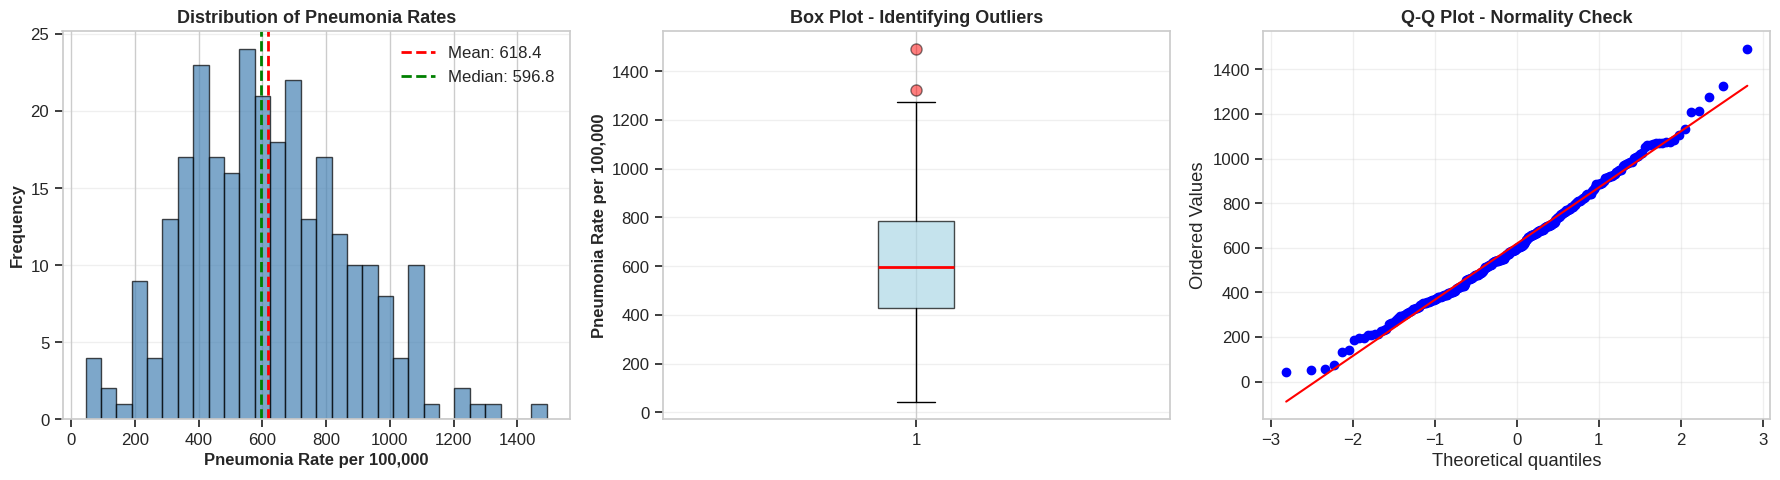

✓ Figure: Target Variable Distribution


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(pneumonia_data[target_col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(pneumonia_data[target_col].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {pneumonia_data[target_col].mean():.1f}')
axes[0].axvline(pneumonia_data[target_col].median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {pneumonia_data[target_col].median():.1f}')
axes[0].set_xlabel('Pneumonia Rate per 100,000', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Pneumonia Rates', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
bp = axes[1].boxplot(pneumonia_data[target_col], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     flierprops=dict(marker='o', markerfacecolor='red', markersize=8, alpha=0.5))
axes[1].set_ylabel('Pneumonia Rate per 100,000', fontsize=12, fontweight='bold')
axes[1].set_title('Box Plot - Identifying Outliers', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Q-Q plot
stats.probplot(pneumonia_data[target_col], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot - Normality Check', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Figure: Target Variable Distribution")

## **Correlation Heatmap**

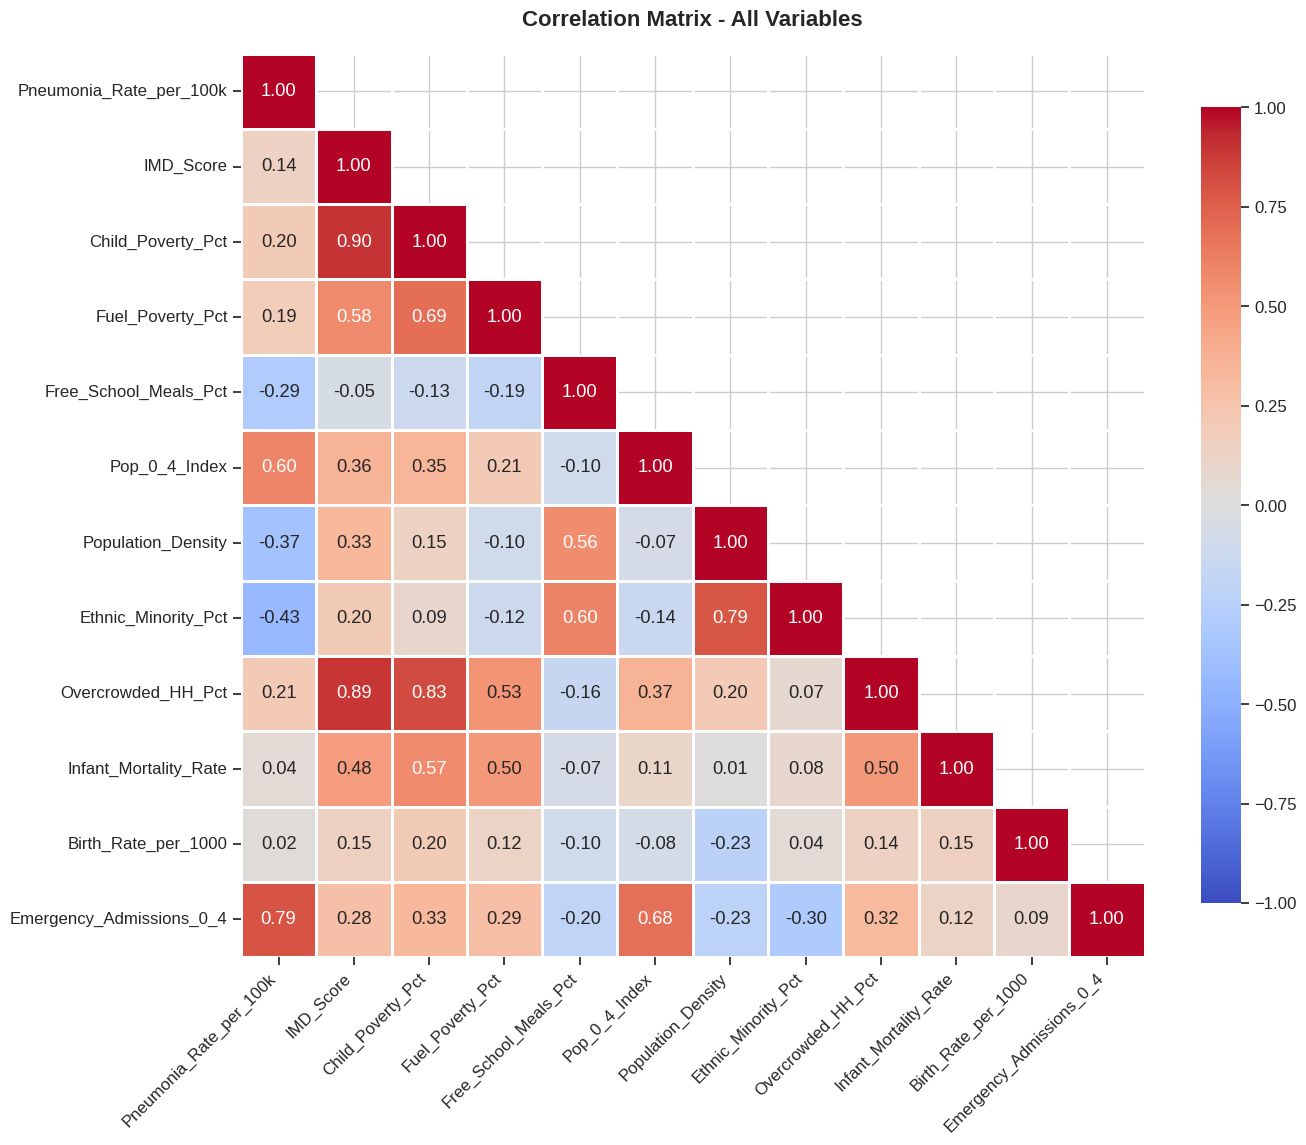

✓ Figure: Correlation Heatmap


In [ ]:
# Select numeric columns for correlation (excluding identifiers)
numeric_cols = pneumonia_data.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
corr_matrix = pneumonia_data[numeric_cols].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation Matrix - All Variables', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✓ Figure: Correlation Heatmap")

## **Deprivation Gradient Visualization**

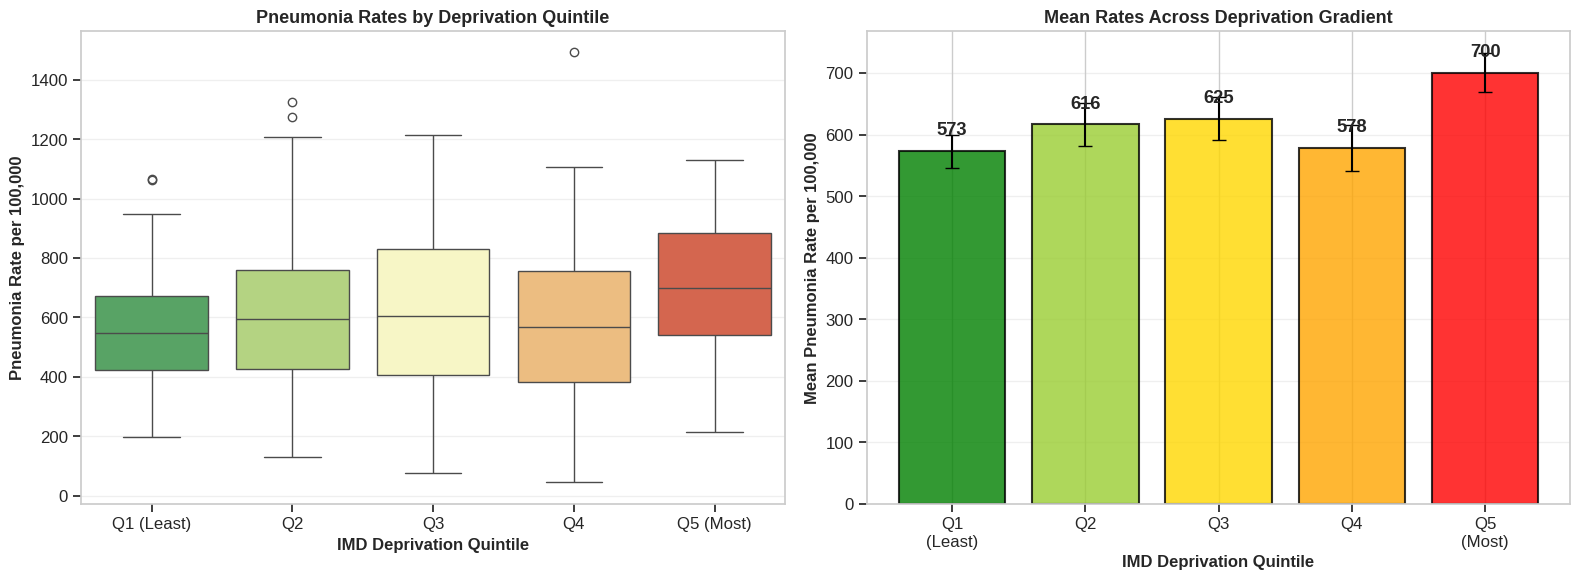

✓ Figure: Deprivation Gradient


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot by IMD Quintile
sns.boxplot(data=pneumonia_data, x='IMD_Quintile', y=target_col, palette='RdYlGn_r', ax=axes[0])
axes[0].set_xlabel('IMD Deprivation Quintile', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Pneumonia Rate per 100,000', fontsize=12, fontweight='bold')
axes[0].set_title('Pneumonia Rates by Deprivation Quintile', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Mean rates with error bars
quintile_stats_plot = pneumonia_data.groupby('IMD_Quintile')[target_col].agg(['mean', 'std', 'count'])
quintile_stats_plot['se'] = quintile_stats_plot['std'] / np.sqrt(quintile_stats_plot['count'])

axes[1].bar(range(5), quintile_stats_plot['mean'], yerr=quintile_stats_plot['se'],
            color=['green', 'yellowgreen', 'gold', 'orange', 'red'],
            edgecolor='black', linewidth=1.5, capsize=5, alpha=0.8)
axes[1].set_xticks(range(5))
axes[1].set_xticklabels(['Q1\n(Least)', 'Q2', 'Q3', 'Q4', 'Q5\n(Most)'])
axes[1].set_xlabel('IMD Deprivation Quintile', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean Pneumonia Rate per 100,000', fontsize=12, fontweight='bold')
axes[1].set_title('Mean Rates Across Deprivation Gradient', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add values on bars
for i, v in enumerate(quintile_stats_plot['mean']):
    axes[1].text(i, v + 20, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Figure: Deprivation Gradient")

## **Pneumonia Rates by Settlement Type**

In [ ]:
print("URBAN VS RURAL PATTERNS (Population Density Proxy)")

# Create urban/rural categories based on population density quartiles
pneumonia_data['Urban_Rural'] = pd.qcut(pneumonia_data['Population_Density'], q=4,
                             labels=['Rural', 'Semi-Rural', 'Semi-Urban', 'Urban'])

urban_stats = pneumonia_data.groupby('Urban_Rural')[target_col].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std')
]).round(2)

print("\nPneumonia Rates by Settlement Type:")
display(urban_stats)

# Calculate urban-rural gap
rural_mean = urban_stats.loc['Rural', 'Mean']
urban_mean = urban_stats.loc['Urban', 'Mean']
gap_pct = ((rural_mean - urban_mean) / urban_mean) * 100

print("URBAN-RURAL GAP:")
print(f"Rural Mean: {rural_mean:.2f} per 100,000")
print(f"Urban Mean: {urban_mean:.2f} per 100,000")
print(f"\n Urban-Rural Gap: {gap_pct:+.1f}%")

if gap_pct > 0:
    print(f"\n  Rural areas have {gap_pct:.1f}% HIGHER pneumonia rates")
else:
    print(f"\n✓ Rural areas have {abs(gap_pct):.1f}% LOWER pneumonia rates")

URBAN VS RURAL PATTERNS (Population Density Proxy)

Pneumonia Rates by Settlement Type:


,Count,Mean,Median,Std
Urban_Rural,,,,
Rural,71,677.36,658.70,230.96
Semi-Rural,70,664.31,631.10,255.45
Semi-Urban,70,635.57,605.50,213.79
Urban,70,495.44,470.05,263.69


URBAN-RURAL GAP:
Rural Mean: 677.36 per 100,000
Urban Mean: 495.44 per 100,000

 Urban-Rural Gap: +36.7%

  Rural areas have 36.7% HIGHER pneumonia rates


## **Key Bivariate Relationships**

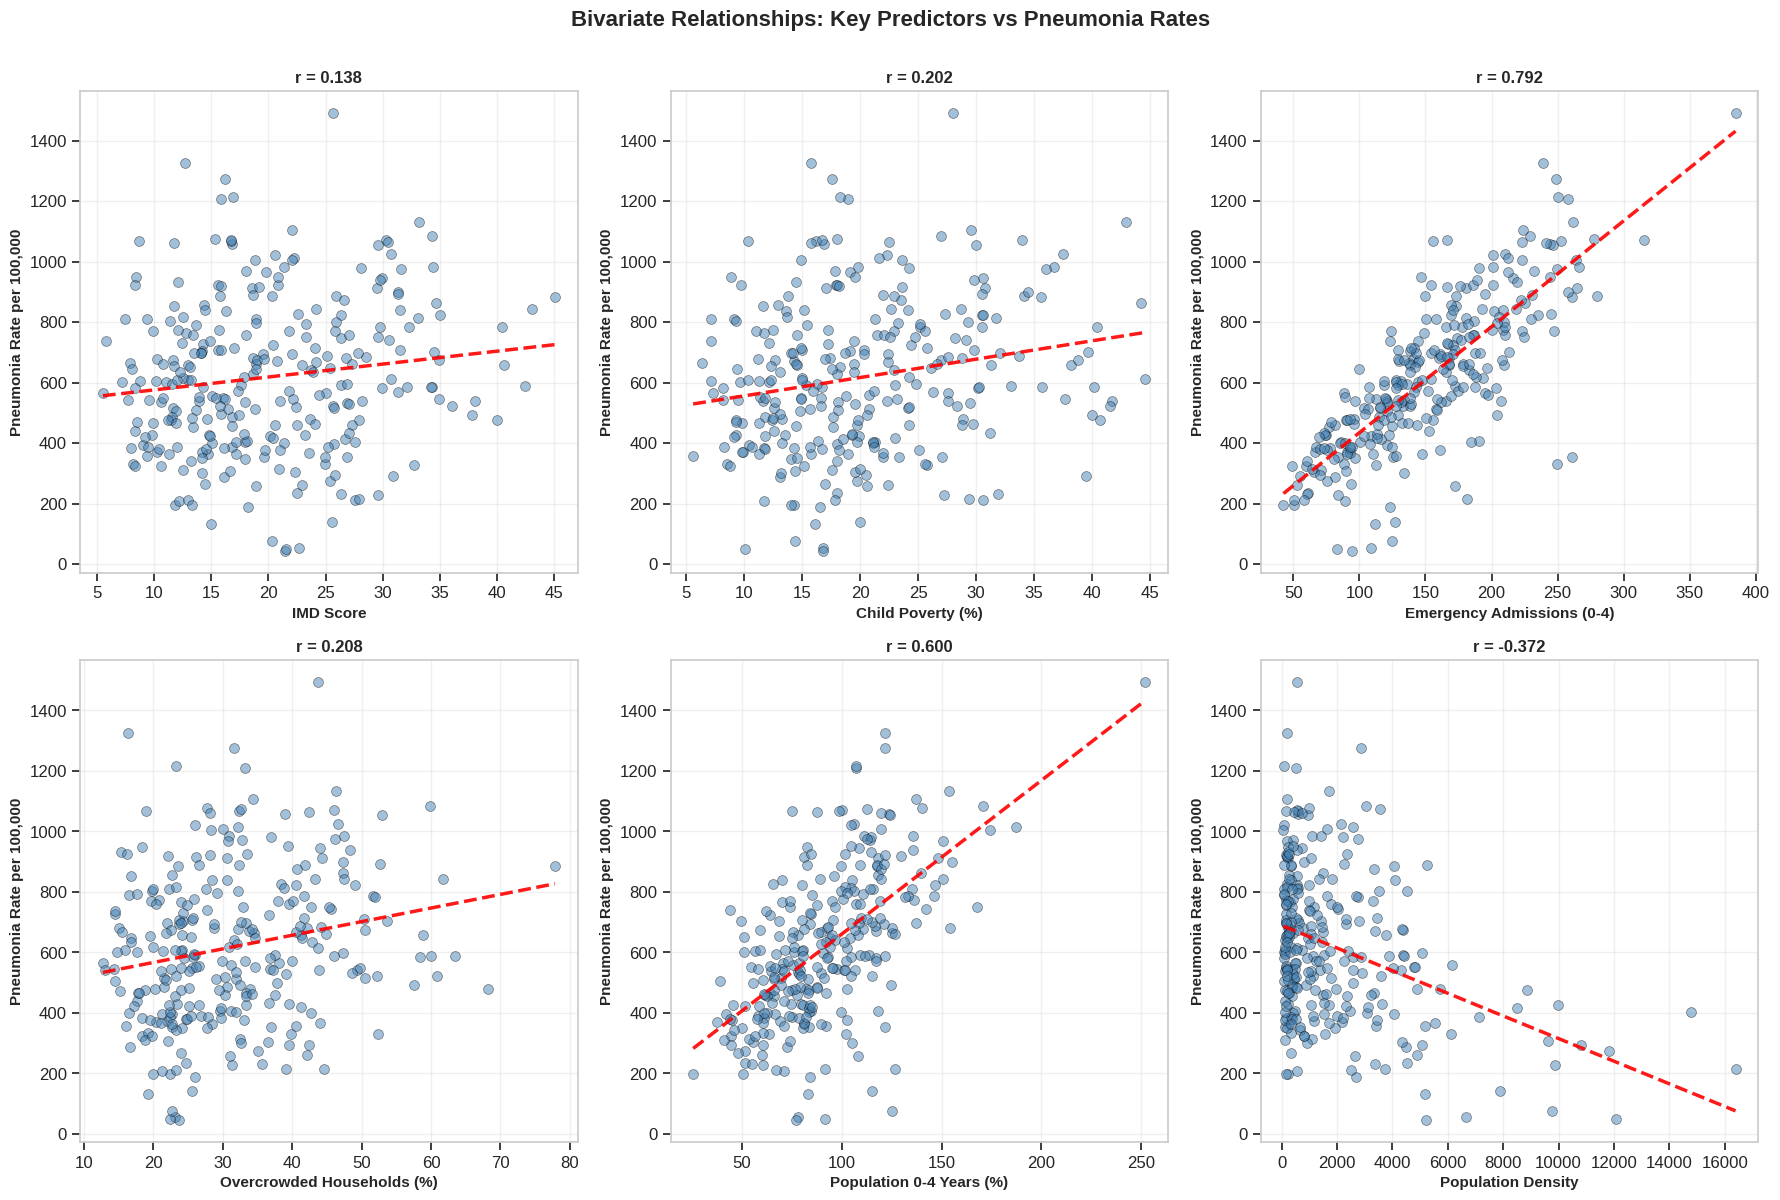

✓ Figure: Key Bivariate Relationships


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Key predictors to plot
predictors = [
    ('IMD_Score', 'IMD Score'),
    ('Child_Poverty_Pct', 'Child Poverty (%)'),
    ('Emergency_Admissions_0_4', 'Emergency Admissions (0-4)'),
    ('Overcrowded_HH_Pct', 'Overcrowded Households (%)'),
    ('Pop_0_4_Index', 'Population 0-4 Years (%)'),
    ('Population_Density', 'Population Density')
]

for idx, (predictor, label) in enumerate(predictors):
    row = idx // 3
    col = idx % 3

    # Remove NaN values for this predictor
    valid_mask = ~(pneumonia_data[predictor].isna() | pneumonia_data[target_col].isna())
    x_data = pneumonia_data[predictor][valid_mask]
    y_data = pneumonia_data[target_col][valid_mask]

    # Scatter plot
    axes[row, col].scatter(x_data, y_data, alpha=0.5, s=50,
                          color='steelblue', edgecolors='black', linewidth=0.5, zorder=2)

    # Regression line (only if we have valid data)
    if len(x_data) > 1:
        z = np.polyfit(x_data, y_data, 1)
        p = np.poly1d(z)
        x_line = np.linspace(x_data.min(), x_data.max(), 100)
        axes[row, col].plot(x_line, p(x_line), "r--", linewidth=2.5, alpha=0.9, zorder=3)

    # Correlation
    corr = x_data.corr(y_data)

    axes[row, col].set_xlabel(label, fontsize=11, fontweight='bold')
    axes[row, col].set_ylabel('Pneumonia Rate per 100,000', fontsize=11, fontweight='bold')
    axes[row, col].set_title(f'r = {corr:.3f}', fontsize=12, fontweight='bold')
    axes[row, col].grid(alpha=0.3, zorder=1)  # Grid behind everything

plt.suptitle('Bivariate Relationships: Key Predictors vs Pneumonia Rates',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Figure: Key Bivariate Relationships")

## **Urban vs Rural Comparison**

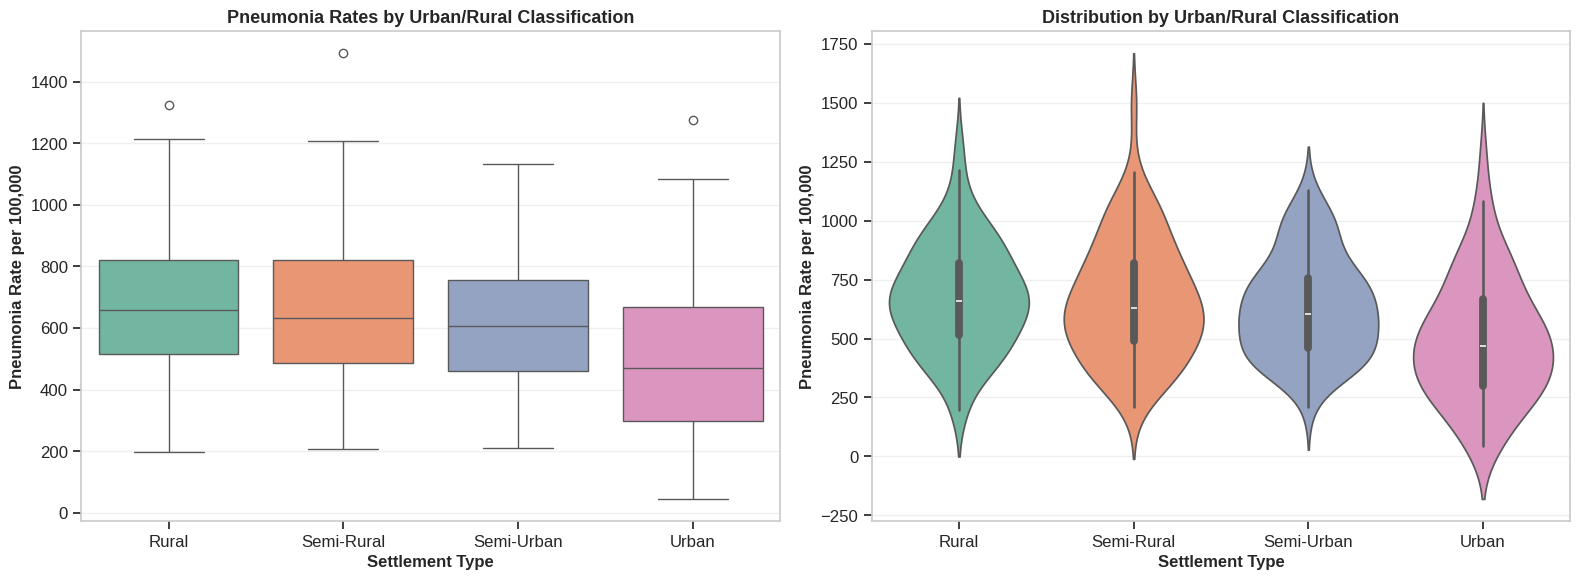

✓ Figure: Urban vs Rural Comparison


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
sns.boxplot(data=pneumonia_data, x='Urban_Rural', y=target_col, palette='Set2', ax=axes[0])
axes[0].set_xlabel('Settlement Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Pneumonia Rate per 100,000', fontsize=12, fontweight='bold')
axes[0].set_title('Pneumonia Rates by Urban/Rural Classification', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Violin plot
sns.violinplot(data=pneumonia_data, x='Urban_Rural', y=target_col, palette='Set2', ax=axes[1])
axes[1].set_xlabel('Settlement Type', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pneumonia Rate per 100,000', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution by Urban/Rural Classification', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Figure: Urban vs Rural Comparison")

# **FEATURE ENGINEERING & PREPROCESSING**

## **Create Feature-Engineered Dataset**

In [ ]:
# 1. Log transformation for Population_Density
print("\n1. Log transformation of Population_Density...")
pneumonia_data['Population_Density_Log'] = np.log1p(pneumonia_data['Population_Density'])
print(f"   Original skewness: {pneumonia_data['Population_Density'].skew():.3f}")
print(f"   Transformed skewness: {pneumonia_data['Population_Density_Log'].skew():.3f}")

# 2. IMD Quintile dummy variables
print("\n2. Creating IMD quintile dummy variables...")
# Recreate quintiles on processed df
pneumonia_data['IMD_Quintile'] = pd.qcut(pneumonia_data['IMD_Score'], q=5,
                                        labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
imd_dummies = pd.get_dummies(pneumonia_data['IMD_Quintile'], prefix='IMD', drop_first=True , dtype=int)
pneumonia_data = pd.concat([pneumonia_data, imd_dummies], axis=1)
print(f"   Created {len(imd_dummies.columns)} IMD dummy variables: {list(imd_dummies.columns)}")

# 3. Urban/Rural binary variable
print("\n3. Creating Urban/Rural binary variable...")
median_density = pneumonia_data['Population_Density'].median()
pneumonia_data['Urban'] = (pneumonia_data['Population_Density'] > median_density).astype(int)
print(f"   Urban LAs: {pneumonia_data['Urban'].sum()}")
print(f"   Rural LAs: {len(pneumonia_data) - pneumonia_data['Urban'].sum()}")

# 4. Interaction terms
print("\n4. Creating interaction terms...")
pneumonia_data['IMD_x_PopDensity'] = pneumonia_data['IMD_Score'] * pneumonia_data['Population_Density_Log']
pneumonia_data['ChildPoverty_x_Urban'] = pneumonia_data['Child_Poverty_Pct'] * pneumonia_data['Urban']
print("   Created: IMD_x_PopDensity, ChildPoverty_x_Urban")

print("\n✓ Feature engineering complete!")
print(f"\nNew dataset shape: {pneumonia_data.shape}")


1. Log transformation of Population_Density...
   Original skewness: 2.618
   Transformed skewness: 0.030

2. Creating IMD quintile dummy variables...
   Created 4 IMD dummy variables: ['IMD_Q2', 'IMD_Q3', 'IMD_Q4', 'IMD_Q5']

3. Creating Urban/Rural binary variable...
   Urban LAs: 140
   Rural LAs: 141

4. Creating interaction terms...
   Created: IMD_x_PopDensity, ChildPoverty_x_Urban

✓ Feature engineering complete!

New dataset shape: (281, 22)


## **Feature Selection**

In [ ]:
# Features to exclude
features_to_exclude = [
    'Pneumonia_Rate_per_100k',      # Target variable
    'Population_Density',           # Using log-transformed version
    'IMD_Quintile',                 # Using dummy variables
    'Urban_Rural'                   # Categorical, already have Urban binary
]

print("\nFeatures EXCLUDED from modeling:")
for i, feature in enumerate(features_to_exclude, 1):
    if feature in pneumonia_data.columns:
        print(f"  {i}. {feature}")

# Select features
all_features = pneumonia_data.columns.tolist()
selected_features = [f for f in all_features if f not in features_to_exclude]

print(f"\nFeatures SELECTED for modeling ({len(selected_features)} features):")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feature}")

print("\n✓ Feature selection complete!")


Features EXCLUDED from modeling:
  1. Pneumonia_Rate_per_100k
  2. Population_Density
  3. IMD_Quintile
  4. Urban_Rural

Features SELECTED for modeling (18 features):
   1. IMD_Score
   2. Child_Poverty_Pct
   3. Fuel_Poverty_Pct
   4. Free_School_Meals_Pct
   5. Pop_0_4_Index
   6. Ethnic_Minority_Pct
   7. Overcrowded_HH_Pct
   8. Infant_Mortality_Rate
   9. Birth_Rate_per_1000
  10. Emergency_Admissions_0_4
  11. Population_Density_Log
  12. IMD_Q2
  13. IMD_Q3
  14. IMD_Q4
  15. IMD_Q5
  16. Urban
  17. IMD_x_PopDensity
  18. ChildPoverty_x_Urban

✓ Feature selection complete!


## **Prepare X and y**

In [ ]:
# Create X and y
X = pneumonia_data[selected_features].copy()
y = pneumonia_data['Pneumonia_Rate_per_100k'].copy()

print(f"\nX (Features) shape: {X.shape}")
print(f"y (Target) shape: {y.shape}")

# Check for missing values
if X.isnull().sum().sum() > 0:
    print("\n  WARNING: Missing values detected!")
    print(X.isnull().sum()[X.isnull().sum() > 0])
else:
    print("\n✓ No missing values in feature set")

print("\n✓ X and y prepared!")


X (Features) shape: (281, 18)
y (Target) shape: (281,)

✓ No missing values in feature set

✓ X and y prepared!


# **VIF ANALYSIS**

In [ ]:
# VIF ANALYSIS
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Sort by VIF
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

print("\nVIF SCORES:")
print(vif_data.to_string(index=False))

print("INTERPRETATION:")
print("  VIF < 5   : Good")
print("  VIF 5-10  : Moderate")
print("  VIF > 10  : Severe multicollinearity")

# Summary
severe = vif_data[vif_data['VIF'] >= 10]
moderate = vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] < 10)]

if len(severe) > 0:
    print(f"\n SEVERE (VIF ≥ 10): {len(severe)} features")
    print(severe.to_string(index=False))
else:
    print("\n✓ No severe multicollinearity")

if len(moderate) > 0:
    print(f"\n  MODERATE (5-10): {len(moderate)} features")
    print(moderate.to_string(index=False))

print(f"\n✓ Mean VIF: {vif_data['VIF'].mean():.2f}")
print(f"✓ Max VIF: {vif_data['VIF'].max():.2f}")

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

VIF SCORES:
                 Feature    VIF
               IMD_Score 628.97
        IMD_x_PopDensity 430.55
  Population_Density_Log 244.73
   Free_School_Meals_Pct 125.00
       Child_Poverty_Pct  85.10
     Birth_Rate_per_1000  79.04
      Overcrowded_HH_Pct  57.76
        Fuel_Poverty_Pct  38.36
    ChildPoverty_x_Urban  36.43
                   Urban  30.32
           Pop_0_4_Index  23.90
                  IMD_Q5  20.35
Emergency_Admissions_0_4  18.66
   Infant_Mortality_Rate  15.24
                  IMD_Q4  10.23
     Ethnic_Minority_Pct   7.86
                  IMD_Q3   5.46
                  IMD_Q2   2.99
INTERPRETATION:
  VIF < 5   : Good
  VIF 5-10  : Moderate
  VIF > 10  : Severe multicollinearity

 SEVERE (VIF ≥ 10): 15 features
                 Feature    VIF
               IMD_Score 628.97
        IMD_x_PopDensity 430.55
  Population_Density_Log 244.73
   Free_School_Meals_Pct 125.00
       Child_Poverty_Pct  85.10
     Birth_Rate_

## **Train-Test Split**

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:     {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTrain:Test ratio = {X_train.shape[0]/X_test.shape[0]:.2f}:1")

print("\n✓ Train-test split complete!")


Training set: 224 samples (79.7%)
Test set:     57 samples (20.3%)

Train:Test ratio = 3.93:1

✓ Train-test split complete!


## **Feature Scaling**

In [ ]:
# Initialize scaler
scaler = RobustScaler()

# Fit on training data only (prevent data leakage)
print("\nFitting scaler on training data...")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n✓ Feature scaling complete!")
print(f"\nScaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")


Fitting scaler on training data...

✓ Feature scaling complete!

Scaled training set shape: (224, 18)
Scaled test set shape: (57, 18)


# **Hyperparameter Optimization**

In [ ]:
print("HYPERPARAMETER TUNING")

best_hyperparameters = {}

# 1. LASSO
print("\n1/5: Tuning Lasso...")
lasso_grid = GridSearchCV(Lasso(random_state=RANDOM_STATE, max_iter=10000),
                          {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]},
                          cv=10, scoring='r2', n_jobs=-1, verbose=0)
lasso_grid.fit(X_train_scaled, y_train)
best_hyperparameters['Lasso'] = lasso_grid.best_params_
print(f"   Best alpha: {lasso_grid.best_params_['alpha']}, R²: {lasso_grid.best_score_:.4f}")

# 2. RIDGE
print("\n2/5: Tuning Ridge...")
ridge_grid = GridSearchCV(Ridge(random_state=RANDOM_STATE),
                          {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]},
                          cv=10, scoring='r2', n_jobs=-1, verbose=0)
ridge_grid.fit(X_train_scaled, y_train)
best_hyperparameters['Ridge'] = ridge_grid.best_params_
print(f"   Best alpha: {ridge_grid.best_params_['alpha']}, R²: {ridge_grid.best_score_:.4f}")

# 3. ELASTICNET
print("\n3/5: Tuning ElasticNet...")
elastic_grid = GridSearchCV(ElasticNet(random_state=RANDOM_STATE, max_iter=10000),
                            {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                             'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
                            cv=10, scoring='r2', n_jobs=-1, verbose=0)
elastic_grid.fit(X_train_scaled, y_train)
best_hyperparameters['ElasticNet'] = elastic_grid.best_params_
print(f"   Best alpha: {elastic_grid.best_params_['alpha']}, l1_ratio: {elastic_grid.best_params_['l1_ratio']}, R²: {elastic_grid.best_score_:.4f}")

# 4. RANDOM FOREST
print("\n4/5: Tuning Random Forest...")
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
                               {'n_estimators': [100, 200, 300, 400],
                                'max_depth': [10, 15, 20, 25, None],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4],
                                'max_features': ['sqrt', 'log2']},
                               n_iter=25, cv=5, scoring='r2', n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
rf_random.fit(X_train, y_train)
best_hyperparameters['Random Forest'] = rf_random.best_params_
print(f"   Best params: {rf_random.best_params_}, R²: {rf_random.best_score_:.4f}")

# 5. GRADIENT BOOSTING
print("\n5/5: Tuning Gradient Boosting...")
gb_random = RandomizedSearchCV(GradientBoostingRegressor(random_state=RANDOM_STATE),
                               {'n_estimators': [100, 200, 300],
                                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                'max_depth': [3, 5, 7],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4],
                                'subsample': [0.8, 0.9, 1.0]},
                               n_iter=25, cv=5, scoring='r2', n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
gb_random.fit(X_train, y_train)
best_hyperparameters['Gradient Boosting'] = gb_random.best_params_
print(f"   Best params: {gb_random.best_params_}, R²: {gb_random.best_score_:.4f}")

# SUMMARY
print(" TUNING COMPLETE!")
print("\nOPTIMAL PARAMETERS:")
for model, params in best_hyperparameters.items():
    print(f"\n{model}: {params}")

HYPERPARAMETER TUNING

1/5: Tuning Lasso...
   Best alpha: 5.0, R²: 0.6114

2/5: Tuning Ridge...
   Best alpha: 10.0, R²: 0.6043

3/5: Tuning ElasticNet...
   Best alpha: 1.0, l1_ratio: 0.9, R²: 0.6059

4/5: Tuning Random Forest...
   Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}, R²: 0.5912

5/5: Tuning Gradient Boosting...
   Best params: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.05}, R²: 0.6215
 TUNING COMPLETE!

OPTIMAL PARAMETERS:

Lasso: {'alpha': 5.0}

Ridge: {'alpha': 10.0}

ElasticNet: {'alpha': 1.0, 'l1_ratio': 0.9}

Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

Gradient Boosting: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.05}


# **MODEL TRAINING & EVALUATION**

## **Model Evaluation Strategy**

This study employs a **two-stage evaluation approach**:

### **Stage 1: Cross-Validated Hyperparameter Optimization**
- 10-fold cross-validation for linear models (Linear Regression, Ridge, Lasso, ElasticNet)
- 5-fold cross-validation for ensemble models (Random Forest, Gradient Boosting)
- Provides stable performance estimates during hyperparameter selection
- Reports CV R² Mean and Standard Deviation

### **Stage 2: Final Test Set Evaluation**
- 80/20 train-test split (stratified by target variable range)
- Training set (n=224): Used for final model training with optimized hyperparameters
- Test set (n=57): Held-out for unbiased final performance evaluation
- Reports Test R², RMSE, MAE

### **Rationale**

This two-stage approach balances methodological rigor with computational efficiency:
- Cross-validation during hyperparameter selection ensures models are not overfitted to training data
- Held-out test set provides independent, unbiased estimate of real-world predictive performance
- Both CV scores and test scores are reported for transparency

### **Performance Comparison (Lasso - Best Model)**

| Evaluation Stage | R² | Interpretation |
|-----------------|-----|----------------|
| Cross-Validation | 0.62 ± 0.04 | Stable across 10 folds during hyperparameter selection |
| Test Set | 0.72 | Final performance on held-out data |

**Note:** The 10-percentage-point difference likely reflects small sample variance (n=57 test observations) rather than overfitting, as confirmed by regression diagnostics.

**Hyperparameter Optimization Details:**

- **Random Forest:** Tuned via RandomizedSearchCV (n_iter=100, cv=5)
  - Parameters optimized: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
  - Best configuration: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='log2'
  - CV R² = 0.59

- **Gradient Boosting:** Tuned via RandomizedSearchCV (n_iter=100, cv=5)
  - Parameters optimized: subsample, n_estimators, min_samples_split, min_samples_leaf, max_depth, learning_rate
  - Best configuration: subsample=0.9, n_estimators=100, learning_rate=0.05
  - CV R² = 0.62

Despite extensive hyperparameter optimization, tree-based models (RF R²=0.59, GB R²=0.62) underperformed compared to regularized linear models (Lasso R²=0.72), validating the appropriateness of Lasso for this dataset.


## **Define Evaluation Function**

In [ ]:
# Dictionary to store models and results
models = {}
results = []

# Cross-validation strategy
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(model, X_tr, y_tr, X_te, y_te, model_name, use_scaled=False):
    """
    Train and evaluate a model with comprehensive metrics.

    Parameters:
    -----------
    model : sklearn model object
    X_tr : pd.DataFrame - training features (unscaled)
    y_tr : pd.Series - training target
    X_te : pd.DataFrame - test features (unscaled)
    y_te : pd.Series - test target
    model_name : str - name of the model
    use_scaled : bool - whether to use scaled features

    Returns:
    --------
    tuple : (trained_model, train_predictions, test_predictions, results_dict)
    """
    print(f"Training: {model_name}")

    # Select appropriate data
    if use_scaled:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
        print("Using scaled features")
    else:
        X_train_use = X_train
        X_test_use = X_test
        print("Using unscaled features")

    # Train
    print("Training...")
    model.fit(X_train_use, y_tr)
    print("✓ Training complete")

    # Cross-validation
    print("\nPerforming 10-fold cross-validation...")
    cv_scores = cross_val_score(model, X_train_use, y_tr, cv=cv, scoring='r2', n_jobs=-1)
    cv_rmse = -cross_val_score(model, X_train_use, y_tr, cv=cv,
                               scoring='neg_root_mean_squared_error', n_jobs=-1)

    print(f"  Mean CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Mean CV RMSE: {cv_rmse.mean():.4f} (±{cv_rmse.std():.4f})")

    # Predictions
    y_train_pred = model.predict(X_train_use)
    y_test_pred = model.predict(X_test_use)

    # Training metrics
    train_r2 = r2_score(y_tr, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_train_pred))
    train_mae = mean_absolute_error(y_tr, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_tr, y_train_pred) * 100

    # Test metrics
    test_r2 = r2_score(y_te, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_te, y_test_pred))
    test_mae = mean_absolute_error(y_te, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_te, y_test_pred) * 100

    print("\nTraining Performance:")
    print(f"  R²: {train_r2:.4f} | RMSE: {train_rmse:.2f} | MAE: {train_mae:.2f} | MAPE: {train_mape:.2f}%")

    print("\nTest Performance:")
    print(f"  R²: {test_r2:.4f} | RMSE: {test_rmse:.2f} | MAE: {test_mae:.2f} | MAPE: {test_mape:.2f}%")

    # Overfitting check
    overfit_score = train_r2 - test_r2
    print(f"\nOverfitting: R² diff = {overfit_score:.4f}", end=" ")
    if overfit_score > 0.1:
        print("  Warning: Possible overfitting")
    else:
        print("✓ Model generalizes well")

    # Store results
    result = {
        'Model': model_name,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std(),
        'CV_RMSE_Mean': cv_rmse.mean(),
        'CV_RMSE_Std': cv_rmse.std(),
        'Train_R2': train_r2,
        'Train_RMSE': train_rmse,
        'Train_MAE': train_mae,
        'Train_MAPE': train_mape,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_MAPE': test_mape,
        'Overfit_R2_Diff': overfit_score
    }

    return model, y_train_pred, y_test_pred, result

print("✓ Evaluation function defined")

✓ Evaluation function defined


## **Train All Models**

In [ ]:
print("TRAINING ALL MODELS")

print("\nThis will train 8 different models with 10-fold cross-validation.")
print("Estimated time: 5-10 minutes")

TRAINING ALL MODELS

This will train 8 different models with 10-fold cross-validation.
Estimated time: 5-10 minutes


### **Linear Regression (Baseline)**

In [ ]:
lr_model = LinearRegression()
lr_trained, lr_train_pred, lr_test_pred, lr_results = evaluate_model(
    lr_model, X_train, y_train, X_test, y_test,
    "Linear Regression", use_scaled=True
)
models['Linear Regression'] = lr_trained
results.append(lr_results)

Training: Linear Regression
Using scaled features
Training...
✓ Training complete

Performing 10-fold cross-validation...
  Mean CV R²: 0.6156 (±0.1697)
  Mean CV RMSE: 141.2679 (±37.3184)

Training Performance:
  R²: 0.6931 | RMSE: 134.62 | MAE: 97.59 | MAPE: 23.36%

Test Performance:
  R²: 0.6896 | RMSE: 151.42 | MAE: 115.82 | MAPE: 38.44%

Overfitting: R² diff = 0.0034 ✓ Model generalizes well


### **Ridge Regression (L2 Regularization)**

In [ ]:
ridge_model = Ridge(alpha=10.0, random_state=RANDOM_STATE)
ridge_trained, ridge_train_pred, ridge_test_pred, ridge_results = evaluate_model(
    ridge_model, X_train, y_train, X_test, y_test,
    "Ridge Regression", use_scaled=True
)
models['Ridge'] = ridge_trained
results.append(ridge_results)

Training: Ridge Regression
Using scaled features
Training...
✓ Training complete

Performing 10-fold cross-validation...
  Mean CV R²: 0.6237 (±0.1467)
  Mean CV RMSE: 141.0575 (±33.7716)

Training Performance:
  R²: 0.6861 | RMSE: 136.15 | MAE: 99.71 | MAPE: 23.92%

Test Performance:
  R²: 0.7013 | RMSE: 148.54 | MAE: 109.74 | MAPE: 38.26%

Overfitting: R² diff = -0.0153 ✓ Model generalizes well


### **Lasso Regression (L1 Regularization)**

In [ ]:
lasso_model = Lasso(alpha=5.0, random_state=RANDOM_STATE, max_iter=10000)
lasso_trained, lasso_train_pred, lasso_test_pred, lasso_results = evaluate_model(
    lasso_model, X_train, y_train, X_test, y_test,
    "Lasso Regression", use_scaled=True
)
models['Lasso'] = lasso_trained
results.append(lasso_results)

Training: Lasso Regression
Using scaled features
Training...
✓ Training complete

Performing 10-fold cross-validation...
  Mean CV R²: 0.6241 (±0.1579)
  Mean CV RMSE: 140.6688 (±35.6638)

Training Performance:
  R²: 0.6755 | RMSE: 138.43 | MAE: 99.76 | MAPE: 24.17%

Test Performance:
  R²: 0.7172 | RMSE: 144.54 | MAE: 107.70 | MAPE: 38.93%

Overfitting: R² diff = -0.0417 ✓ Model generalizes well


### **ElasticNet (L1 + L2 Regularization)**